In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [2]:
def read_data(data_file_name):
    prob_y = []
    prob_x = []
    for line in open(data_file_name):
        line = line.split(None, 1)
        # In case an instance with all zero features
        if len(line) == 1: line += ['']
        label, features = line
        xi = {}
        for e in features.split():
            ind, val = e.split(":")
            xi[int(ind)] = float(val)
        prob_y += [float(label)]
        prob_x += [xi]
    d = max([max(x.keys()) for x in prob_x])
    X = []
    for f in prob_x:
        x = np.zeros(d)
        for k,v in f.items():
            x[k-1] = v
        X.append(x)
    
    return (np.array(prob_y),np.array(X))

In [3]:
[b, A] = read_data('a9a.txt')
n, d = A.shape
A = np.hstack((np.ones((n,1)), A))
d = d+1
A = A / np.sqrt((A**2).sum(axis=0))

In [4]:
class Ridge_Logistic_Regression():
    
    def __init__(self, lambd=0.1):
        self.lambd = lambd
        
    def loss(self, A, b, x):
        return np.sum(np.log(1 + np.exp(-b * (A @ x)))) + 0.5*self.lambd*(x**2).sum()
        
    def gradient(self, A, b, x):
        return -A.T @ (b/(1 + np.exp(b * (A @ x))))
#         return -b/(1 + np.exp(b*(A.dot(x))))
        
    def hessian(self, A, b, x):
        '''
        Computation in matrix form to find augmented diagonal matrix 
        '''
        return (1/(1 + np.exp(b * (A @ x)))) * (1/(1 + np.exp(-b * (A @ x))))
        
    

In [5]:
def row_norm_squares_sampling(A, b, x, rl):
    '''
    Block Norm Squares Sampling The first option is to construct a sampling distribution based on the
    magnitude of Ai. That is, define
    https://arxiv.org/pdf/1607.00559.pdf
    '''
    B = np.sqrt(rl.hessian(A, b, x))[:, np.newaxis] * A
    B_norm_2 = np.linalg.norm(B, 'fro') ** 2
    Bi_norm_2 = np.linalg.norm(B, axis=1) ** 2 # row-wise
    
    return Bi_norm_2/B_norm_2 # probability of selection for each i,...,n

def conjugate_gd(A, b, x, tol):
    rk = A @ x - b
    pk = -rk
    xk = x.copy()
    k = 0
    while(np.linalg.norm(rk) > tol):
        alpha_k = (rk.T @ rk) / (pk.T @ A @ pk)# 4
        
        xk = xk + alpha_k * pk # 5
        rk_1 = rk + alpha_k * A @ pk # 5
        
        beta_k_1 = (rk_1.T @ rk_1) / (rk.T @ rk)
        pk = -rk_1 + beta_k_1 * pk
        
        rk = rk_1        
        k = k + 1
        
    return xk
     

In [6]:
def gd(A, b, x0, rl, lambd, iters):
    x = x0
    x_arr, t = [], []
    x_arr.append(0)
    t.append(0)
    alpha = 0.5
    start = time.time()
    for j in range(iters):
        g = rl.gradient(A,b,x) + lambd * x
        x = x - alpha * g
        x_arr.append(x.copy())
        t.append(time.time() - start)
    
    end = time.time()
    print(f'GD computation time: {end-start}')
    return x_arr, t
    
def accelerated_gd(A, b, x0, rl, lambd, iters):
    x_prev = x0
    x = x0.copy()
    x_arr, t = [], []
    x_arr.append(0)
    t.append(0)
    alpha = 0.5
    start = time.time()
    for j in range(2, iters+2):
#         beta = (j-2)/(j+1)
        beta = 0.72
        y = x + (beta * (x - x_prev))
        g = rl.gradient(A,b,y) + lambd * y
        x_prev = x
        x = y - alpha * g
        x_arr.append(x.copy())
        t.append(time.time() - start)
    
    end = time.time()
    print(f'AGD computation time: {end-start}')
    return x_arr, t

def newton(A, b, x0, rl, lambd, iters):
    x_stars = x0
    x_stars_arr, t = [], []
    x_stars_arr.append(0)
    t.append(0)
    start = time.time()
    for j in range(iters):
        B = rl.hessian(A, b, x_stars) 
        H = (A.T * B) @ (A) + lambd * np.eye(d)
        g = rl.gradient(A,b,x_stars) + lambd * x_stars
        p = np.linalg.solve(H, -g)
        x_stars += p
        x_stars_arr.append(x_stars.copy())
        t.append(time.time() - start)
    
    end = time.time()
    print(f'Newton computation time: {end-start}')
    return x_stars_arr, t 

def sub_sampled_newton_rnss(A, b, x0, rl, lambd, iters):
    np.random.seed(42)
    n, d = A.shape
    x = x0
    x_arr, t = [], []
    x_arr.append(0)
    t.append(0)
    start = time.time()
    for j in range(iters):
        prob = row_norm_squares_sampling(A,b,x,rl)
        q = np.minimum(20 * d * prob, 1)
        i = np.random.rand(n) < q # sub-sampled indices
        Ai = A[i,:] # features X
        bi = b[i] # y
        qi = q[i]
        Bi = rl.hessian(Ai, bi, x) # refer to Ai(w) in paper
        B_tilde = (np.sqrt(Bi)/np.sqrt(qi))[:,np.newaxis] * Ai
        H_tilde = B_tilde.T @ B_tilde + lambd * np.eye(d)
#         H_tilde = Ai.T @ (Ai * ((Bi/qi)[:,np.newaxis])) + lambd * np.eye(d)
        g = rl.gradient(A,b,x) + lambd * x # g(w)
        p = np.linalg.solve(H_tilde, -g) # might use conjugate gd??
        x +=  p
        x_arr.append(x.copy())
        t.append(time.time() - start)
        
    end = time.time()
    print(f'Sub-sampled Newton rnss computation time: {end-start}')
    return x_arr, t

In [7]:
rl = Ridge_Logistic_Regression()
iters = 25
lambd = 0.1
w_stars = newton(A, b, np.zeros(d), rl, lambd, 30)[0][29]

w0, t0 = newton(A, b, np.zeros(d), rl, lambd, iters)
w1, t1 = sub_sampled_newton_rnss(A, b, np.zeros(d), rl, lambd, iters)
w2, t2 = gd(A, b, np.zeros(d), rl, lambd, 200)
w3, t3 = accelerated_gd(A, b, np.zeros(d), rl, lambd, 200)

Newton computation time: 18.385873079299927
Newton computation time: 11.011793851852417
Sub-sampled Newton rnss computation time: 3.0354530811309814
GD computation time: 5.310932159423828
AGD computation time: 5.5207109451293945


In [8]:
ith = 26
w_gaps0, w_gaps1, w_gaps2, w_gaps3  = [], [], [], []

for k in range(ith):
    w_gaps0.append(np.linalg.norm(w0[k] - w_stars)/np.linalg.norm(w_stars))
    w_gaps1.append(np.linalg.norm(w1[k] - w_stars)/np.linalg.norm(w_stars))
for k in range(201):
    w_gaps2.append(np.linalg.norm(w2[k] - w_stars)/np.linalg.norm(w_stars))
    w_gaps3.append(np.linalg.norm(w3[k] - w_stars)/np.linalg.norm(w_stars))

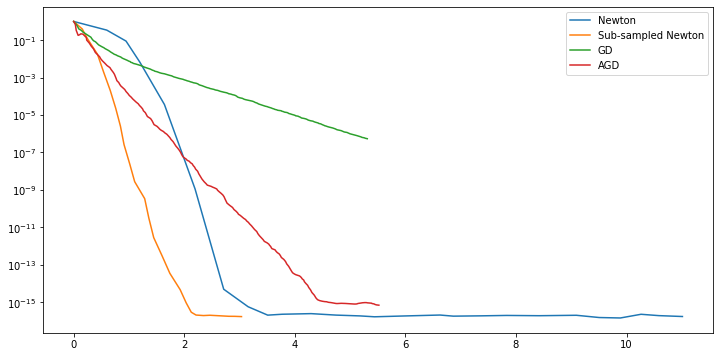

In [9]:
fig = plt.figure(figsize=(12, 6)) # set figure size
plt.yscale('log')
plt.plot(t0 , w_gaps0, label='Newton') 
plt.plot(t1 , w_gaps1, label='Sub-sampled Newton') 
plt.plot(t2 , w_gaps2, label='GD') 
plt.plot(t3, w_gaps3, label='AGD') 
plt.legend()

In [10]:
ith = 25
f_stars = []
f0, f1, f2, f3 = [], [], [], []
for k in range(ith):
    f0.append(rl.loss(A, b, w0[k]) - rl.loss(A, b, w_stars))
for k in range(ith*2):
    f1.append(rl.loss(A, b, w1[k]) - rl.loss(A, b, w_stars))
for k in range(ith*8):
    f2.append(rl.loss(A, b, w2[k]) - rl.loss(A, b, w_stars))
    f3.append(rl.loss(A, b, w3[k]) - rl.loss(A, b, w_stars))

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [ ]:
fig = plt.figure(figsize=(12, 6)) # set figure size
plt.yscale('log')
plt.plot(t0 , f0, label='Newton') 
plt.plot(t1 , f1, label='Sub-sampled Newton') 
plt.plot(t2 , f2, label='GD') 
plt.plot(t3 , f3, label='AGD') 
plt.legend()